# Simple2D_DIC

Minimal tutorial to run **D2IC** on **2 images** (reference + deformed) and visualize the displacement field.

Data used: `doc/img/PlateHole/ohtcfrp_00.tif` (reference), `doc/img/PlateHole/ohtcfrp_10.tif` (deformed), and the ROI mask `doc/img/PlateHole/roi.tif`.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import sys

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

from D2IC.dic import Dic
from D2IC.dic_plotter import DICPlotter
from D2IC import generate_roi_mesh


def _configure_jax_platform(preferred="gpu", fallback="cpu"):
    """Try GPU first when available, otherwise fall back to CPU."""
    try:
        devices = jax.devices(preferred)
    except RuntimeError:
        devices = []
    if devices:
        jax.config.update("jax_platform_name", preferred)
        print(f"JAX backend: {preferred} ({len(devices)} device(s) detected)")
    else:
        jax.config.update("jax_platform_name", fallback)
        print(f"JAX backend: {preferred} unavailable, falling back to {fallback}.")


_configure_jax_platform()
jax.devices()

JAX backend: gpu (1 device(s) detected)


W1218 13:26:52.767850   30439 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1218 13:26:52.770625    4439 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


[CudaDevice(id=0)]

## 1) Load 2 images + ROI mask

im_ref: (1040, 400) float64
im_def: (1040, 400) float64
mask : (1040, 400, 4) uint8


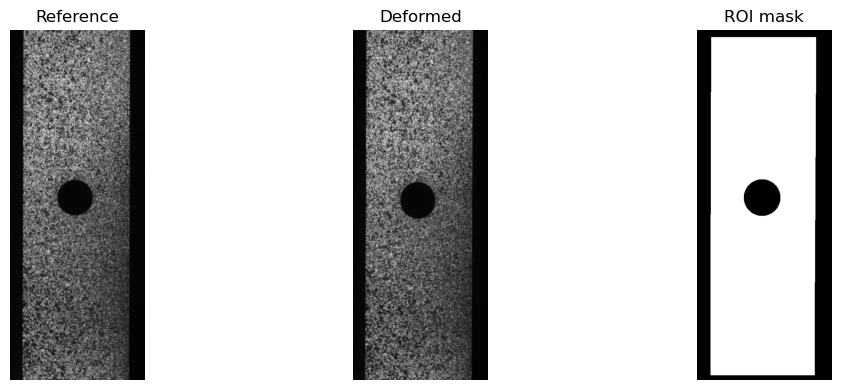

In [2]:

repo_root = None
current = Path.cwd().resolve()
for candidate in (current, *current.parents):
    img_root = candidate / "doc" / "img" / "PlateHole"
    if img_root.exists():
        repo_root = candidate
        break
if repo_root is None:
    raise FileNotFoundError(
        "Could not locate the repository root (doc/img/PlateHole folder missing)."
    )

img_dir = repo_root / "doc" / "img" / "PlateHole"
out_dir = Path("./_outputs")
out_dir.mkdir(exist_ok=True)

im_ref = imread(img_dir / "ohtcfrp_00.tif").astype(float)
im_def = imread(img_dir / "ohtcfrp_10.tif").astype(float)
mask = imread(img_dir / "roi.tif")

print("im_ref:", im_ref.shape, im_ref.dtype)
print("im_def:", im_def.shape, im_def.dtype)
print("mask :", mask.shape, mask.dtype)

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax[0].imshow(im_ref, cmap="gray", origin="lower")
ax[0].set_title("Reference")
ax[1].imshow(im_def, cmap="gray", origin="lower")
ax[1].set_title("Deformed")
ax[2].imshow(mask, cmap="gray", origin="lower")
ax[2].set_title("ROI mask")
for a in ax:
    a.axis("off")
plt.tight_layout()


## 2) Generate an ROI mesh (from the mask)

The mesh is generated once and reused in subsequent runs.

In [ ]:
mask_path = img_dir / "roi.tif"
mesh_path = out_dir / "Simple2D_DIC_roi_mesh.msh"


mesh_path_generated = generate_roi_mesh(mask_path, element_size=20.0, msh_path=str(mesh_path))
if mesh_path_generated is None:
    raise RuntimeError("Mesh generation failed.")
mesh_path = Path(mesh_path_generated)

mesh_path

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Circle)
Info    : [ 70%] Meshing curve 6 (Circle)
Info    : [ 80%] Meshing curve 7 (Circle)
Info    : [ 90%] Meshing curve 8 (Circle)
Info    : Done meshing 1D (Wall 0.000406715s, CPU 0.000555s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Blossom: 3184 internal 160 closed
Info    : Blossom recombination completed (Wall 0.0193629s, CPU 0.019475s): 1071 quads, 0 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.787633, min Q = 0.507001
Info    : Done meshing 2D (Wall 0.0359664s, CPU 0.036335s)
Info    : 1155 nodes 1243 elements
Info    : Writing '_outputs/Simple2D_DIC_roi_mesh_40px.msh'...
Info    : Done writing '_outputs/Simple2D_DIC_roi_mesh_40px.msh'


PosixPath('_outputs/Simple2D_DIC_roi_mesh_40px.msh')

## 3) Create the DIC object

We precompute pixel-level quantities (on the reference image).

In [4]:
dic = Dic(mesh_path=str(mesh_path))
dic.precompute_pixel_data(jnp.asarray(im_ref))

dic

Dic(mesh_path=_outputs/Simple2D_DIC_roi_mesh_40px.msh)

## 4) Estimate an initial displacement (big motion)

D2IC can estimate an initial field using sparse correspondences (patch matching + RANSAC).

Retained matches: 14


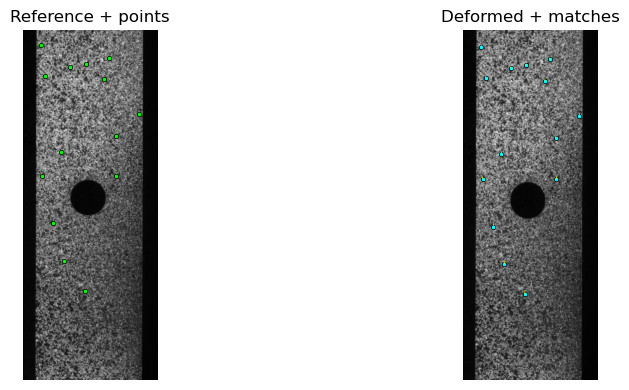

In [5]:
disp_guess, extras = dic.compute_feature_disp_guess_big_motion(
    im_ref,
    im_def,
    n_patches=32,
    patch_win=21,
    patch_search=15,
    refine=True,
    search_dilation=5.0,
)

pts_ref = extras["pts_ref"]
pts_def = extras["pts_def"]
print("Retained matches:", pts_ref.shape[0])

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
ax[0].imshow(im_ref, cmap="gray", origin="lower")
ax[0].scatter(pts_ref[:, 0], pts_ref[:, 1], s=10, c="lime", edgecolors="k", linewidths=0.5)
ax[0].set_title("Reference + points")

ax[1].imshow(im_def, cmap="gray", origin="lower")
ax[1].scatter(pts_def[:, 0], pts_def[:, 1], s=10, c="cyan", edgecolors="k", linewidths=0.5)
ax[1].quiver(
    pts_ref[:, 0],
    pts_ref[:, 1],
    pts_def[:, 0] - pts_ref[:, 0],
    pts_def[:, 1] - pts_ref[:, 1],
    angles="xy",
    scale_units="xy",
    scale=1.0,
    color="yellow",
    width=0.003,
)
ax[1].set_title("Deformed + matches")

for a in ax:
    a.axis("off")
plt.tight_layout()

disp_guess = np.asarray(disp_guess, dtype=float)

## 5) Solve global DIC

Pixelwise solve with spring regularization (`reg_type="spring"`).

Last state: [4.06463432 0.00945609]


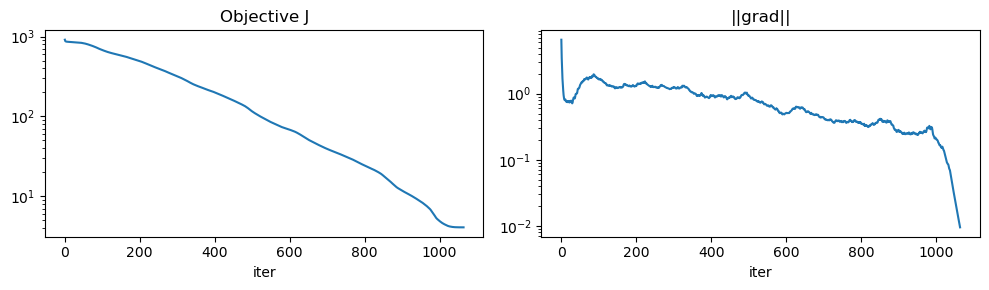

In [ ]:
displacement, history = dic.run_dic(
    im_ref,
    im_def,
    disp_guess=disp_guess,
    max_iter=400,
    tol=1e-3,
    reg_type="spring",
    alpha_reg=0.1,
    save_history=True,
)

hist = np.asarray(history)
print("Last state:", hist[-1])

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].semilogy(hist[:, 0])
ax[0].set_title("Objective J")
ax[0].set_xlabel("iter")
ax[1].semilogy(hist[:, 1])
ax[1].set_title("||grad||")
ax[1].set_xlabel("iter")
plt.tight_layout()

## 6) Visualize the displacement field

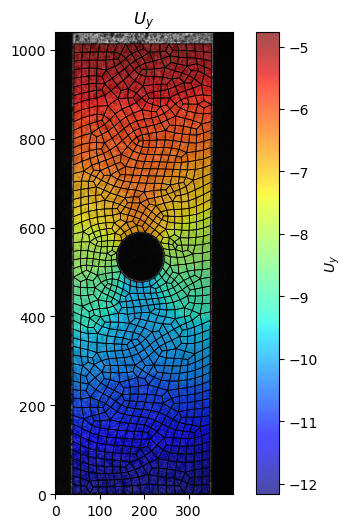

In [7]:
plotter = DICPlotter(
    background_image=im_def,
    displacement=np.asarray(displacement),
    dic_object=dic,
)

fig, _ = plotter.plot_displacement_component("Uy", image_alpha=0.7)
plt.show()

## 7) (Optional) Local nodal refinement 

To obtain a smoother field 

[Nodal-spring_jacobi] sweep 1/10, J=3.8115e+00
[Nodal-spring_jacobi] sweep 2/10, J=4.7249e+00
[Nodal-spring_jacobi] sweep 3/10, J=4.9053e+00
[Nodal-spring_jacobi] sweep 4/10, J=4.9898e+00
[Nodal-spring_jacobi] sweep 5/10, J=5.0268e+00
[Nodal-spring_jacobi] sweep 6/10, J=5.0476e+00
[Nodal-spring_jacobi] sweep 7/10, J=5.0602e+00
[Nodal-spring_jacobi] sweep 8/10, J=5.0685e+00
[Nodal-spring_jacobi] sweep 9/10, J=5.0742e+00
[Nodal-spring_jacobi] sweep 10/10, J=5.0782e+00


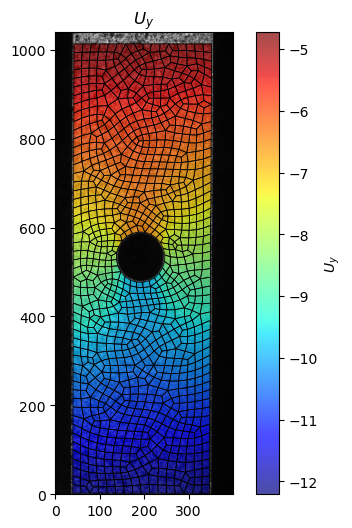

<Figure size 640x480 with 0 Axes>

In [8]:
displacement_refined = dic.run_dic_nodal(
    im_ref,
    im_def,
    disp_init=displacement,
    n_sweeps=10,
    lam=0.1,
    reg_type="spring_jacobi",
    alpha_reg=1.0,
    max_step=0.2,
    omega_local=0.5,
)

plotter = DICPlotter(
    background_image=im_def,
    displacement=np.asarray(displacement_refined),
    dic_object=dic,
)
fig, _ = plotter.plot_displacement_component("Uy", image_alpha=0.7)

plt.savefig(out_dir / "Simple2D_DIC_Ohtcfrp_Uy_field.png", dpi=300)
plt.show()

fig, _ = plotter.plot_displacement_component("Ux", image_alpha=0.7)
plt.savefig(out_dir / "Simple2D_DIC_Ohtcfrp_Ux_field.png", dpi=300)
plt.show()

## 8 ) Estimate strains at the nodes

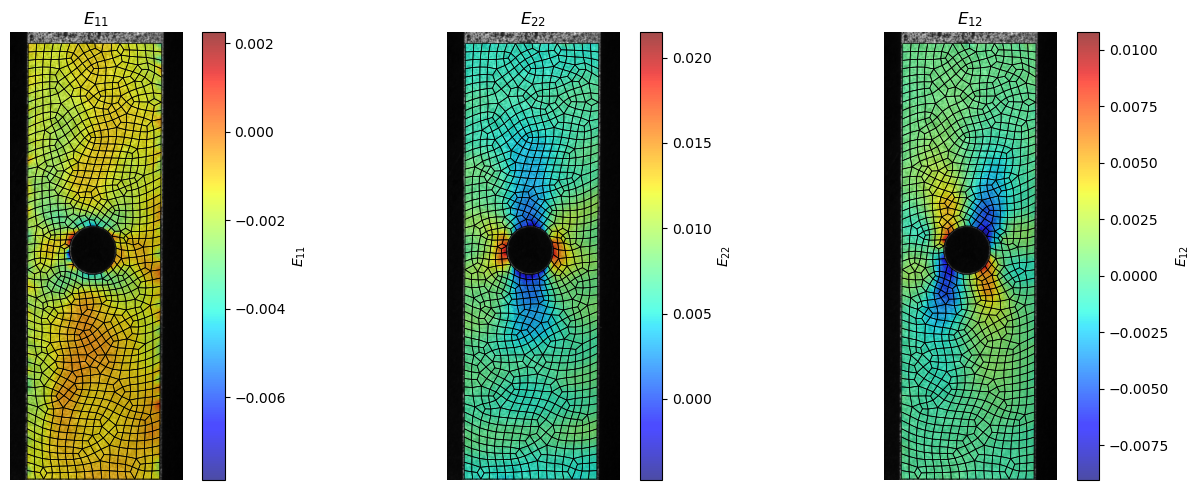

In [9]:
F_all, E_all = dic.compute_green_lagrange_strain_nodes(
    displacement_refined,
    k_ring=2,
    gauge_length=40.0,
)

plotter_strain = DICPlotter(
    background_image=im_def,
    displacement=displacement_refined,
    strain_fields=(F_all, E_all),
    dic_object=dic,
)

def plot_scalar_field(ax, field_name, cmap="jet", image_alpha=0.7):
    ax.imshow(plotter_strain.background_image, cmap="gray", origin="lower", alpha=1.0)
    field_map = plotter_strain._get_scalar_field_map(field_name)
    masked = np.ma.array(field_map, mask=~np.isfinite(field_map))
    mesh = ax.imshow(masked, cmap=cmap, origin="lower", alpha=image_alpha)
    quad_mesh = plotter_strain._quad_mesh_collection()
    if quad_mesh is not None:
        ax.add_collection(quad_mesh)
    ax.set_aspect("equal")
    ax.set_title(plotter_strain._latex_label(field_name, "strain"))
    ax.set_axis_off()
    return mesh

fields = [
    ("Exx", "Exx"),
    ("Eyy", "Eyy"),
    ("Exy", "Exy"),
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for ax, (field_name, _) in zip(axes, fields):
    mesh = plot_scalar_field(ax, field_name)
    label = plotter_strain._latex_label(field_name, "strain")
    fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.04, label=label)

plt.tight_layout()


plt.savefig(out_dir / "Simple2D_DIC_Ohtcfrp_Estrain_fields.png", dpi=300)
plt.show()